In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# !pip install emoji

     |████████████████████████████████| 133kB 17.0MB/s 


In [28]:
import emoji

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import string

import re

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [4]:
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier


from wordcloud import WordCloud



In [5]:
#For Stemming, NLTK is needed
import nltk
from nltk.stem.snowball import SnowballStemmer

import spacy
nlp = spacy.load('en')

In [7]:
df_train =pd.read_csv("/content/drive/My Drive/nlp_disaster/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/nlp_disaster/test.csv")

In [ ]:
# Some data is wrong. For example, target of the training dataset at 328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226 are given as 1 whereas they are obviously 0, since they are not related to disaster.

# We change it to 0.

ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
df_train.at[df_train['id'].isin(ids_with_target_error),'target'] = 0
df_train[df_train['id'].isin(ids_with_target_error)]

In [8]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Exploratory Data Analysis (EDA)
Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Check various aspects of the dataset. It may or may not be useful.

Checking which all columns contain NaN values(is missing). 'location' is missing a lot in both the train and test data sets

In [9]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [11]:
# Count number of words in tweet and maximum count

count = df_train['text'].str.split().str.len()
count
print(max(count))

31


In [12]:
print("Train dataset shape : ",df_train.shape)
print("Test dataset shape : ",df_test.shape)

Train dataset shape :  (7613, 5)
Test dataset shape :  (3263, 4)


In [13]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


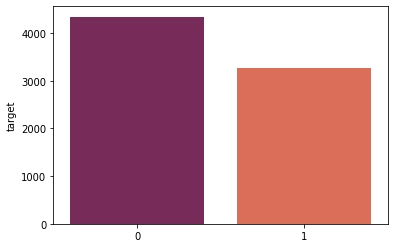

In [14]:
sns.barplot(df_train['target'].value_counts().index,df_train['target'].value_counts(),palette='rocket')

In [15]:
# Lets explore the keyword column and see if it's useful

df_train['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
sinking                  41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

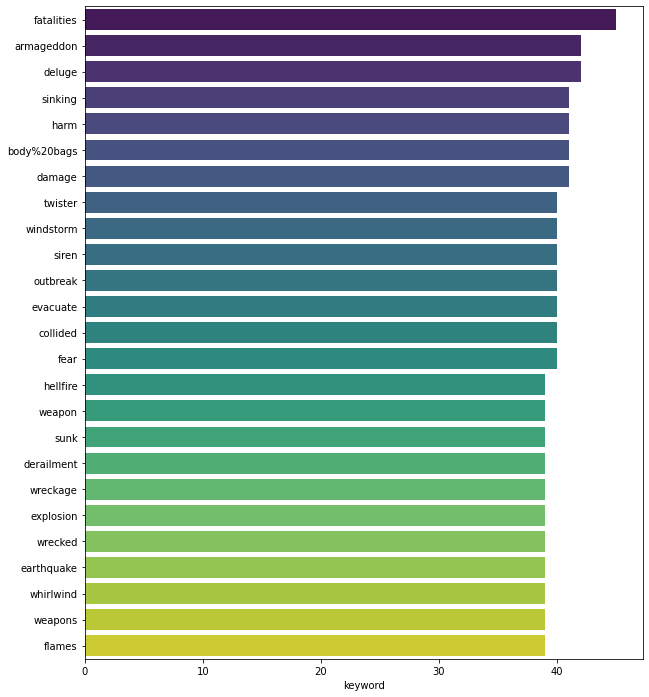

In [16]:
# Lets display first 25 as there are too many to display whole. Putting horizontal orientation and viridis palette.
plt.figure(figsize=(10, 12))
sns.barplot(y=df_train['keyword'].value_counts()[:25].index,x=df_train['keyword'].value_counts()[:25], orient='horizontal', palette='viridis')


In [17]:
# Lets explore the target column

# Lets see 5 tweets about a disaster.

# A disaster tweet
disaster_tweets = df_train[df_train['target']==1]['text']
disaster_tweets.values[:5]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

In [18]:
# Lets see 5 non-disaster tweets

non_disaster_tweets = df_train[df_train['target']==0]['text']
non_disaster_tweets.values[:5]

array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal!!!!!!'], dtype=object)

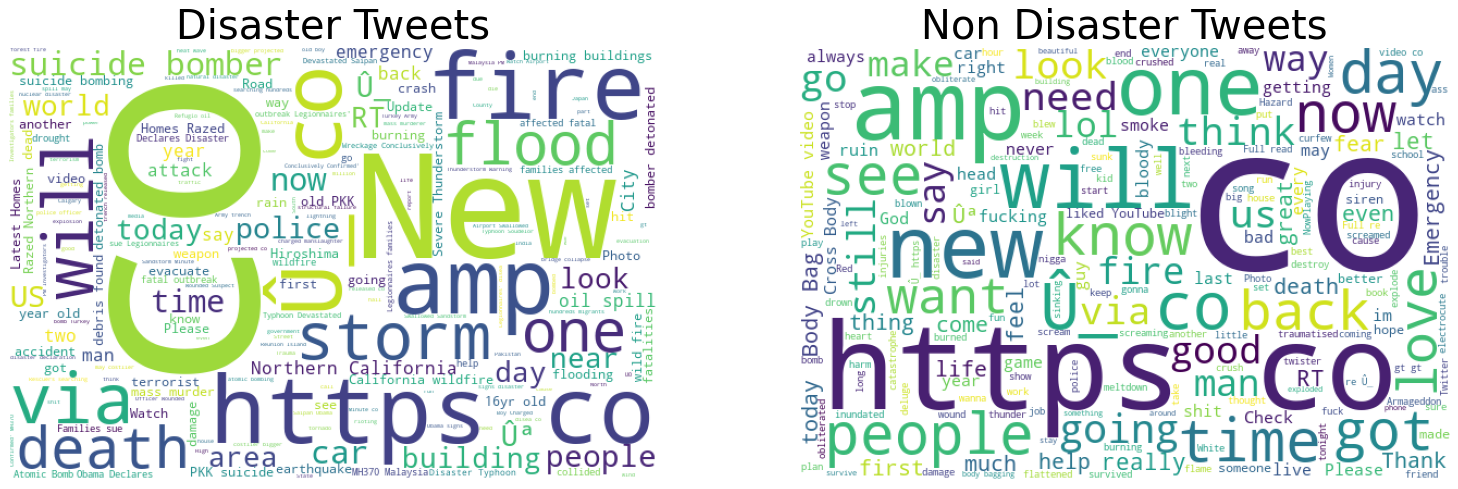

In [19]:
# Generate a WordCloud for disaster tweets and non-disaster tweets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

Preprocessing the data

Data cleaning is the process of fixing or removing incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset

We will create a 'clean' function which comprises of various cleaning function such as removal of emojis, punctuations etc

In [21]:
def clean(text):
    text = text.lower() #Lets make it lowercase
    text = removeStopwords(text)
    text = removePunctuations(text)
    text = removeEmojis(text)
    text = removeNumbers(text)
    text = removeLinks(text)
    return text


def removeStopwords(text):
    doc = nlp(text)
    clean_text = ' '
    for txt in doc:
        if (txt.is_stop == False):
            clean_text = clean_text + " " + str(txt)        
    
    return clean_text


In [22]:

print("Text before removeStopwords function: " + df_train['text'][3])
print("Text after removeStopwords function: " + removeStopwords(df_train['text'][3]))

Text before removeStopwords function: 13,000 people receive #wildfires evacuation orders in California 
Text after removeStopwords function:   13,000 people receive # wildfires evacuation orders California


In [24]:
def removePunctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))


In [25]:

print("Text before removePunctuations function: " + df_train['text'][1])
print("Text after removePunctuations function: " + removePunctuations(df_train['text'][1]))

Text before removePunctuations function: Forest fire near La Ronge Sask. Canada
Text after removePunctuations function: Forest fire near La Ronge Sask Canada


In [34]:
def removeEmojis(text):
    allchars = [c for c in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI["en"]]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

test_string = "Hi' 🤔 , 🙈 and 😌. Have a nice weekend 👭".lower()
print(test_string)
print(removeEmojis(test_string))

hi' 🤔 , 🙈 and 😌. have a nice weekend 👭
hi' , and have a nice weekend


In [36]:
def removeNumbers(text):
    clean_text = re.sub(r'\d+', '', text)
    return clean_text

test_string = "Hi 🙈 are running"
(test_string,removeNumbers(test_string))

('Hi 🙈 are running', 'Hi 🙈 are running')

In [37]:
def removeLinks(text):
    clean_text = re.sub('https?://\S+|www\.\S+', '', text)
    #https? will match both http and https
    #A|B, where A and B can be arbitrary REs, creates a regular expression that will match either A or B.
    #\S Matches any character which is not a whitespace character.
    #+ Causes the resulting RE to match 1 or more repetitions of the preceding RE. ab+ will match ‘a’ followed by any non-zero number of ‘b’s; it will not match just ‘a’.
    return clean_text

test_string = "http://www.youtube.com/ and https://www.youtube.com/ should be removed "
(test_string,removeLinks(test_string))

('http://www.youtube.com/ and https://www.youtube.com/ should be removed ',
 ' and  should be removed ')

In [38]:
df_train['text']=df_train.text.apply(clean)
df_test['text']=df_test.text.apply(clean)

In [39]:
# Checking if the transformation is applied as expected, in the text column

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake allah forgive,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [40]:
# # Some data is wrong. For example, target of the training dataset at 328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226 are given as 1 whereas they are obviously 0, since they are not related to disaster.

# # We change it to 0.

# ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
# df_train.at[df_train['id'].isin(ids_with_target_error),'target'] = 0
# df_train[df_train['id'].isin(ids_with_target_error)]

,id,keyword,location,text,target
229,328,annihilated,NaN,ready annihilated bucs game,0
301,443,apocalypse,NaN,short reading apocalypse spirit angel took en...,0
356,513,army,Studio,build army dogs leader lion dogs fight like lion,0
1822,2619,crashed,NaN,ipod crashed weloveyoulouis mtvhottest direction,0
2536,3640,desolation,"Quilmes , Arg",desperation dislocation separation condemnatio...,0
2715,3900,devastated,PG Chillin!,man currensy talkin talk devastated ghostwrite...,0
3024,4342,dust%20storm,chicago,going fest bring swimming goggles dust storm c...,0
4068,5781,forest%20fires,NaN,campsite recommendations toilets shower pub fi...,0
4609,6552,injury,Saint Paul,prediction vikings game sunday dont expect lot...,0
4611,6554,injury,NaN,dante exum knee injury stem jazz hoped surge h...,0


Text Normalization

Text normalization is the process of transforming text into a canonical (standard) form. For example, the word “gooood” and “gud” can be transformed to “good”, its canonical form. Another example is mapping of near identical words such as “stopwords”, “stop-words” and “stop words” to just “stopwords”.

In [41]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [42]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

    
df_train['text']=df_train.text.apply(convert_abbrev)
df_test['text']=df_test.text.apply(convert_abbrev)

Stemming

We will use NLTK for stemming since Spacy doesn't contain any function for stemming as it relies on lemmatization only There are two types of stemmers in NLTK: Porter Stemmer and Snowball stemmers. Snowball stemmer is a slightly improved version of the Porter stemmer and is usually preferred over the latter. So we will use that.

Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word. Stemming follows an algorithm with steps to perform on the words which makes it faster.

In [43]:
stemmer = SnowballStemmer(language='english')

tokens = df_train['text'][1].split()
clean_text = ' '

for token in tokens:
    print(token + ' --> ' + stemmer.stem(token))

forest --> forest
fire --> fire
near --> near
la --> la
ronge --> rong
sask --> sask
canada --> canada


In [44]:
def stemWord(text):
    stemmer = SnowballStemmer(language='english')
    tokens = text.split()
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + stemmer.stem(token)      
    
    return clean_text

print("Text before stemWord function: " + df_train['text'][1])
print("Text after stemWord function: " + stemWord(df_train['text'][1]))

Text before stemWord function: forest fire near la ronge sask canada
Text after stemWord function:   forest fire near la rong sask canada


In [45]:
df_train['text']=df_train.text.apply(stemWord)
df_test['text']=df_test.text.apply(stemWord)

In [46]:
# df_train.text

# for txt in df_train.text[:40]:
#     print(txt)
                       

  deed reason earthquak allah forgiv
  forest fire near la rong sask canada
  resid ask shelter place notifi offic evacu shelter place order expect
  peopl receiv wildfir evacu order california
  got sent photo rubi alaska smoke wildfir pour school
  rockyfir updat california hwi close direct lake counti fire cafir wildfir
  flood disast heavi rain caus flash flood street manitou colorado spring area
  hill fire wood
  emerg evacu happen build street
  afraid tornado come area
  peopl die heat wave far
  haha south tampa get flood hah wait second live south tampa gon na gon na fvck flood
  rain flood florida tampabay tampa day lost count
  flood bago myanmar arriv bago
  damag school bus multi car crash break
  man
  love fruit
  summer love
  car fast
  goooooooaaaaaal
  ridicul
  london cool
  love ski
  wonder day
  looooool
  way eat shit
  nyc week
  love girlfriend
  cooool
  like pasta
  end
  bbcmtd wholesal market ablaz httptcolhyxeohyc
  tri bring heavi metal rt httptcoyaoexn

Lemmatization

Though we could not perform stemming with spaCy, we can perform lemmatization using spaCy. This is a time consuming process.

Output of lemmatization is an actual word in English unlike Stemming. (word.lemma_ will print word's lemma in SPacy)

In [47]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
#for token in doc:
   # print(token.lemma_)
for noun in doc.noun_chunks:
    print(noun.text)

Apple
U.K. startup


In [48]:
for word in doc:
    print(word.text,  word.lemma_)

Apple Apple
is be
looking look
at at
buying buy
U.K. U.K.
startup startup
for for
$ $
1 1
billion billion


In [49]:
def lemmatizeWord(text):
    tokens=nlp(text)
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + token.lemma_      
    
    return clean_text

print("Text before lemmatizeWord function: " + df_train['text'][1])
print("Text after lemmatizeWord function: " + lemmatizeWord(df_train['text'][1]))

doc = "Apple is looking at buying U.K. startup for $1 billion"
lemmatizeWord(doc)

Text before lemmatizeWord function:   forest fire near la rong sask canada
Text after lemmatizeWord function:      forest fire near la rong sask canada


'  Apple be look at buy U.K. startup for $ 1 billion'

In [50]:
# lemmatizeWord converts words into its lemma form. (Will take a while to run)

df_train['text']=df_train.text.apply(lemmatizeWord)
df_test['text']=df_test.text.apply(lemmatizeWord)

Transforming tokens to a vector

Bag of Words model

A bag-of-words (B.o.w) is a representation of text that describes the occurrence of words within a document. It involves two things:

A vocabulary of known words. A measure of the presence of known words. It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

In [51]:
count_vectorizer = CountVectorizer()
train_bag = count_vectorizer.fit_transform(df_train['text'])
test_bag = count_vectorizer.transform(df_test["text"])

TFIDF Features

Another common representation is TF-IDF (Term Frequency - Inverse Document Frequency). TF-IDF is similar to bag of words except that each term count is scaled by the term's frequency in the corpus. Using TF-IDF can potentially improve your models.

Term Frequency: is a scoring of the frequency of the word in the current document.

TF = (Number of times term t appears in a document)/(Number of terms in the document)

Inverse Document Frequency: is a scoring of how rare the word is across documents.

IDF = 1+log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

In [52]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(df_train['text'])
test_tfidf = tfidf.transform(df_test["text"])

Word Vectors/Word Embeddings

A word embedding is a learned representation for text where words that have the same meaning have a similar representation. It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems.

TIP: Don't use standard preprocessing steps like stemming or stopword removal when you have pre-trained embeddings

In [54]:
# with nlp.disable_pipes():
#     train_vectors = np.array([nlp(text).vector for text in df_train.text])
#     test_vectors = np.array([nlp(text).vector for text in df_test.text])

Building a Text Classification Model

Let's try out different classifiers on word embeddings representation train_vectors and test_vectors

In [ ]:
# Support Vector Machines
# Set dual=False to speed up training, and it's not needed

svc_wordEmbed = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc_wordEmbed.fit(train_vectors, df_train.target)

In [ ]:
Evaluate F1 Score using scikit learns model_selection.cross_val_score

scores = model_selection.cross_val_score(svc_wordEmbed, train_vectors, df_train["target"], cv=3, scoring="f1")
scores